In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import re
import traceback
import string
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# General Information about Data Sets

In [2]:
train= pd.read_csv('cleaned_train.csv')
weather= pd.read_csv('cleaned_weather.csv')
spray= pd.read_csv('cleaned_spray.csv')
spray['Date']=pd.to_datetime(spray['Date'])
train['Date']=pd.to_datetime(train['Date'])
weather['Date']=pd.to_datetime(weather['Date'])
train['Year'] = pd.DatetimeIndex(train['Date']).year
train['Week'] = pd.DatetimeIndex(train['Date']).week
train['YearWeek']= (train['Year'].astype(str)+train['Week'].astype(str)).astype('int64')


C:\Users\laptop\anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  


In [3]:
print(train.info(),weather.info(),spray.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9693 entries, 0 to 9692
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          9693 non-null   datetime64[ns]
 1   Species       9693 non-null   object        
 2   Latitude      9693 non-null   float64       
 3   Longitude     9693 non-null   float64       
 4   NumMosquitos  9693 non-null   int64         
 5   WnvPresent    9693 non-null   int64         
 6   Day           9693 non-null   int64         
 7   Year          9693 non-null   int64         
 8   Week          9693 non-null   int64         
 9   YearWeek      9693 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(1)
memory usage: 757.4+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1472 entries, 0 to 1471
Data columns (total 26 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   

# Spray Data Analysis

## Haversine Distance

In [4]:
from datetime import timedelta

def haversine(lon1, lat1, lon2, lat2):

    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    haver_formula = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    dist = 2 * np.arcsin(np.sqrt(haver_formula ))
    mile = 3959 * dist 
    return mile

def sprayed(day,dist,traps, sprays):

    s = [] 
    for i,r  in traps.iterrows():
      
        mask = (sprays['Date'].dt.to_period('D') == (r[0].to_period('D'))- timedelta(days=day))

        if mask.sum() == 0:
            s.append(0)
            continue
        masked_spray = sprays[mask]
        d= haversine(masked_spray.iloc[:,2],masked_spray.iloc[:,1], r[3],r[2])
      
        #if the closest spray in the time period is within the cutoff distance, assign 1, otherwise 0
        if d.min() <= dist:
            s.append(1) 
        else: 
            s.append(0)

    return s

In [5]:
train['spray_day'] = sprayed(0,1,train,spray)

## Spray_day and WNV relation

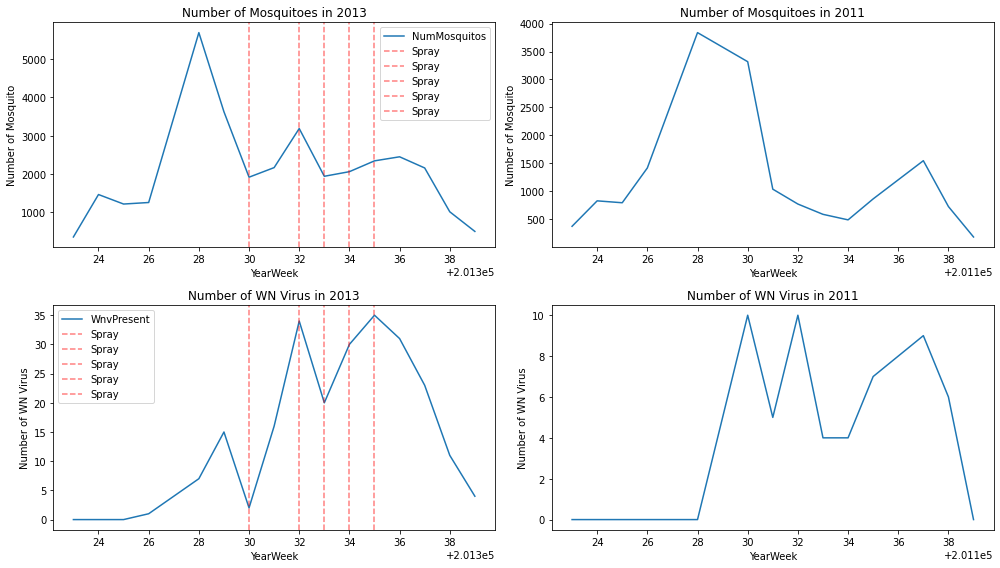

In [6]:
train_2013= train[train['Year']==2013]
train_2011=train[train['Year']==2011]

plt.subplot(2,2,1)

day=list(train[train['spray_day']==1]['YearWeek'].unique())
#  [201330, 201332, 201333, 201334, 201335]
train_2013.groupby('YearWeek')['NumMosquitos'].sum().plot(figsize=(14,8))
for d in day:
    plt.axvline(d, linestyle='--', color='red', alpha=0.5, label='Spray')
    
plt.legend()
plt.xlabel('YearWeek')
plt.ylabel('Number of Mosquito')
plt.title('Number of Mosquitoes in 2013')


plt.subplot(2,2,2)
train_2011.groupby('YearWeek')['NumMosquitos'].sum().plot(figsize=(14,8))
plt.xlabel('YearWeek')
plt.ylabel('Number of Mosquito')
plt.title('Number of Mosquitoes in 2011')
plt.tight_layout()

plt.subplot(2,2,3)
day=list(train[train['spray_day']==1]['YearWeek'].unique())
train_2013.groupby('YearWeek')['WnvPresent'].sum().plot(figsize=(14,8))
for d in day:
    plt.axvline(d, linestyle='--', color='red', alpha=0.5, label='Spray')
    
plt.legend()
plt.xlabel('YearWeek')
plt.ylabel('Number of WN Virus')
plt.title('Number of WN Virus in 2013')


plt.subplot(2,2,4)

train_2011.groupby('YearWeek')['WnvPresent'].sum().plot(figsize=(14,8))
plt.xlabel('YearWeek')
plt.ylabel('Number of WN Virus')
plt.title('Number of WN Virus in 2011')
plt.tight_layout()
plt.show()

## Permutation Test

Null Hypothesis: Spraying has no effect on virus. We assume spraying and WNV Presence is unrelated. Therefore rearrangements should be equal. So I shuffled 'Spray_day' values into 'shuffled_spray'. 

In [7]:
train['shuffled_spray_day']= np.random.permutation(train['spray_day'])
train.groupby('WnvPresent')['shuffled_spray_day'].describe()

,count,mean,std,min,25%,50%,75%,max
WnvPresent,,,,,,,,
0,9190.0,0.006311,0.079196,0.0,0.0,0.0,0.0,1.0
1,503.0,0.005964,0.077074,0.0,0.0,0.0,0.0,1.0


In [8]:
train.groupby('WnvPresent')['spray_day'].describe()

,count,mean,std,min,25%,50%,75%,max
WnvPresent,,,,,,,,
0,9190.0,0.005332,0.072829,0.0,0.0,0.0,0.0,1.0
1,503.0,0.023857,0.152755,0.0,0.0,0.0,0.0,1.0


In [9]:
observed_mean_diff=train[train['WnvPresent']==1]['spray_day'].mean() -train[train['WnvPresent']==0]['spray_day'].mean()
print('observed_diff= ', observed_mean_diff)
shuffled_mean_diff=train[train['WnvPresent']==1]['shuffled_spray_day'].mean() -train[train['WnvPresent']==0]['shuffled_spray_day'].mean()                                                                           
print(('shuffled_diff= ', shuffled_mean_diff))    

observed_diff=  0.018524976365960927
('shuffled_diff= ', -0.0003469931228732067)


The difference in the means for Shuffle (-0.0035) is quite different to our observed difference(0.0185). It looks as if observed difference is significant and Null Hypothesis is null. But to be sure, I will create 10,000 permutations.

In [10]:
difference= list()

for i in range(10000):
    spray_perm=np.random.permutation(train['spray_day'])
    difference.append(np.mean(spray_perm[train['WnvPresent']==1]) - np.mean(spray_perm[train['WnvPresent']==0]))

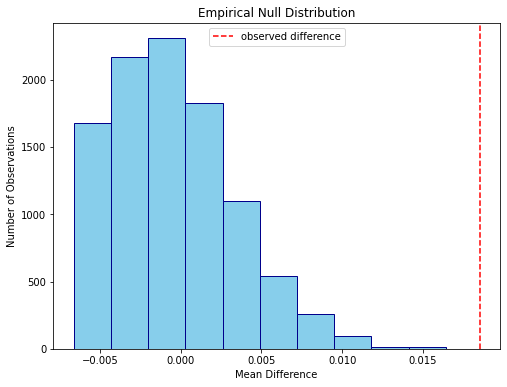

In [11]:
plt.figure(figsize=(8,6))
histo = plt.hist(difference, color = 'skyblue', edgecolor = 'darkblue')
plt.axvline(observed_mean_diff, c='r', linestyle='--', label='observed difference')
plt.xlabel('Mean Difference')
plt.ylabel('Number of Observations')
plt.title('Empirical Null Distribution')
plt.legend()
plt.show()

The observed total variation distance of 0.0185 is nowhere near the distribution generated assuming the null hypothesis is true. The data support the alternative hypothesis: the spraying is highly related to WNV presence.

In [12]:
differ= np.array(difference)
p=np.sum(differ>observed_mean_diff)/len(difference)
print(p)

0.0


The p-value of our observed data is 0, which means our observed data is statistically significant, and we reject the Null. So it showed that spraying reduced the WNV occurence.

In [13]:
train.drop(['YearWeek','Year','Week','shuffled_spray_day'],axis=1, inplace=True)

# Weather & Train Data Sets - EDA and Feature Engineering

In [14]:
# calculation of RELATIVE HUMIDITY
def rel_humidity(df,T, Td,Tw):
    
# Convert the air temperature and dew-point temperature to Celsius.(C=5*(F-32)/9)
    Tc= (5.0*(df[T]-32))/9.0
    Tdc= (5.0*(df[Td]-32))/9.0

#Calculate the saturated vapor pressure with a formula.  
    es=6.11*10.0**(7.5*Tc/(237.7+Tc))

#Find the actual vapor pressure with the same formula.
    e=6.11*10.0**(7.5*Tdc/(237.7+Tdc))
    
#Calculate the relative humidity.    
    return round((e/es)*100)

In [15]:
weather.insert(loc=7, column='RelHumidity', value=(rel_humidity(weather,'Tavg','DewPoint', 'WetBulb')))
weather.head()

,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,RelHumidity,Heat,Cool,...,TS,HZ,RA,FG,TSRA,DZ,Year,Month,YearWeek,YearMonth
0,2007-05-01,83,51,67,14.0,51.0,56.5,56.0,0.0,2.5,...,0.0,0.0,0.0,0.0,0.0,0.0,2007,5,200718,20075
1,2007-05-02,59,42,51,-3.0,42.0,47.0,71.0,13.5,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,2007,5,200718,20075
2,2007-05-03,66,47,57,2.0,40.0,49.0,53.0,8.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,2007,5,200718,20075
3,2007-05-04,72,50,61,4.0,41.5,50.0,49.0,4.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,2007,5,200718,20075
4,2007-05-05,66,53,60,5.0,38.5,49.5,45.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2007,5,200718,20075


In [16]:
w_train= train.merge(weather, on='Date')
w_train.head()

,Date,Species,Latitude,Longitude,NumMosquitos,WnvPresent,Day,spray_day,Tmax,Tmin,...,TS,HZ,RA,FG,TSRA,DZ,Year,Month,YearWeek,YearMonth
0,2007-05-29,CULEX PIPIENS/RESTUANS,41.954690,-87.800991,1,0,29,0,88,62,...,0.0,1.0,0.0,0.0,0.0,0.0,2007,5,200722,20075
1,2007-05-29,CULEX RESTUANS,41.954690,-87.800991,1,0,29,0,88,62,...,0.0,1.0,0.0,0.0,0.0,0.0,2007,5,200722,20075
2,2007-05-29,CULEX RESTUANS,41.994991,-87.769279,1,0,29,0,88,62,...,0.0,1.0,0.0,0.0,0.0,0.0,2007,5,200722,20075
3,2007-05-29,CULEX PIPIENS/RESTUANS,41.974089,-87.824812,1,0,29,0,88,62,...,0.0,1.0,0.0,0.0,0.0,0.0,2007,5,200722,20075
4,2007-05-29,CULEX RESTUANS,41.974089,-87.824812,4,0,29,0,88,62,...,0.0,1.0,0.0,0.0,0.0,0.0,2007,5,200722,20075


In [17]:
def ema(df,col, span):
    df[f'{col}_ema{span}']= round(df[col].ewm(span=span).mean().dropna(),2)
    return df
ema_list= ['spray_day','BR','HZ','RA','TSRA','TS','DZ','FG','Heat','Cool','Tmin','Tmax', 'Tavg','DewPoint','WetBulb','PrecipTotal', 'StnPressure','SeaLevel', 'ResultSpeed', 'ResultDir', 'AvgSpeed','RelHumidity']
span= list(np.arange(2,8)) + list(np.arange(8,30,2)) +list(np.arange(30,60,5))
for i in ema_list:
     for s in span:
        ema(w_train,i,s)

In [18]:
def lagged(df,col, span):
    df[f'{col}_lag{span}']= round(df[col].rolling(span, min_periods=1).mean().dropna(),2)
    return df
roll_list= ['spray_day','BR','HZ','RA','TSRA','TS','DZ','FG','Heat','Cool','Tmin','Tmax', 'Tavg','DewPoint','WetBulb','PrecipTotal', 'StnPressure','SeaLevel', 'ResultSpeed', 'ResultDir', 'AvgSpeed','RelHumidity']
span= list(np.arange(2,8)) + list(np.arange(8,30,2)) +list(np.arange(30,60,5))
for i in roll_list:
     for s in span:
        lagged(w_train,i,s)

In [19]:
w_train.head( )

,Date,Species,Latitude,Longitude,NumMosquitos,WnvPresent,Day,spray_day,Tmax,Tmin,...,RelHumidity_lag22,RelHumidity_lag24,RelHumidity_lag26,RelHumidity_lag28,RelHumidity_lag30,RelHumidity_lag35,RelHumidity_lag40,RelHumidity_lag45,RelHumidity_lag50,RelHumidity_lag55
0,2007-05-29,CULEX PIPIENS/RESTUANS,41.954690,-87.800991,1,0,29,0,88,62,...,57.0,57.0,57.0,57.0,57.0,57.0,57.0,57.0,57.0,57.0
1,2007-05-29,CULEX RESTUANS,41.954690,-87.800991,1,0,29,0,88,62,...,57.0,57.0,57.0,57.0,57.0,57.0,57.0,57.0,57.0,57.0
2,2007-05-29,CULEX RESTUANS,41.994991,-87.769279,1,0,29,0,88,62,...,57.0,57.0,57.0,57.0,57.0,57.0,57.0,57.0,57.0,57.0
3,2007-05-29,CULEX PIPIENS/RESTUANS,41.974089,-87.824812,1,0,29,0,88,62,...,57.0,57.0,57.0,57.0,57.0,57.0,57.0,57.0,57.0,57.0
4,2007-05-29,CULEX RESTUANS,41.974089,-87.824812,4,0,29,0,88,62,...,57.0,57.0,57.0,57.0,57.0,57.0,57.0,57.0,57.0,57.0


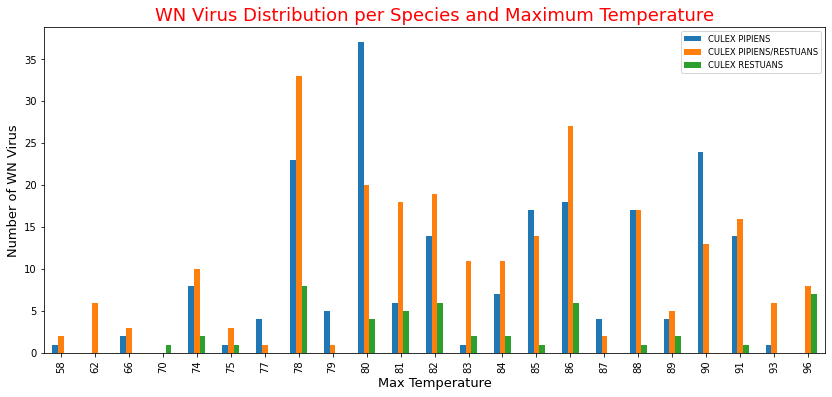

In [20]:
Virus_Species_Month=w_train[w_train['WnvPresent']==1].groupby(['Tmax'])['Species'].value_counts().unstack().fillna(0)
Virus_Species_Month.plot.bar(figsize=(14,6))
plt.grid(False)
plt.legend(bbox_to_anchor=(1, 1), fontsize='small')
plt.xlabel('Max Temperature', fontsize=13)
plt.ylabel('Number of WN Virus', fontsize=13)
plt.title('WN Virus Distribution per Species and Maximum Temperature', fontsize=18, color='red')
plt.show() 

In [21]:
w_train=pd.get_dummies(w_train,drop_first=True, dtype=int)  #>> YUKARIDA SPECIES ICIN 0-1 CALISTIRDIK..
w_train= w_train.drop(['Species_CULEX TERRITANS', 'Species_CULEX SALINARIUS', 'Species_CULEX TARSALIS'], axis=1)

In [24]:
print('\n','The Percantage of Virus per Each Species  ','\n')
print('CULEX PIPIENS: ', round(w_train[w_train.WnvPresent==1]['Species_CULEX PIPIENS'].sum()/len(w_train[w_train.WnvPresent==1]['Species_CULEX PIPIENS'])*100,2))
print('CULEX RESTUANS: ', round(w_train[w_train.WnvPresent==1]['Species_CULEX RESTUANS'].sum()/len(w_train[w_train.WnvPresent==1]['Species_CULEX RESTUANS'])*100,2))
print('CULEX PIPIENS/RESTUANS: ', round(w_train[w_train.WnvPresent==1]['Species_CULEX PIPIENS/RESTUANS'].sum()/len(w_train[w_train.WnvPresent==1]['Species_CULEX PIPIENS/RESTUANS'])*100),2)


 The Percantage of Virus per Each Species   

CULEX PIPIENS:  41.35
CULEX RESTUANS:  9.74
CULEX PIPIENS/RESTUANS:  49.0 2


In [25]:
pd.options.mode.use_inf_as_na = True
max_bin = 30
force_bin = 2

# define a binning function
def mono_bin(Y, X, n = max_bin):

    
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    r = 0
    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            n = n - 1 
        except Exception as e:
            n = n - 1

    if len(d2) == 1:
        n = force_bin         
        bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
        d2 = d1.groupby('Bucket', as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    
    return(d3)

def char_bin(Y, X):
        
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]    
    df2 = notmiss.groupby('X',as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.sum().Y.index
    d3["MAX_VALUE"] = d3["MIN_VALUE"]
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]      
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    d3 = d3.reset_index(drop=True)
    
    return(d3)

def data_vars(df1, target):
    
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]
    
    x = df1.dtypes.index
    count = -1
    
    for i in x:
        if i.upper() not in (final.upper()):
            if np.issubdtype(df1[i], np.number) and len(Series.unique(df1[i])) > 2:
                conv = mono_bin(target, df1[i])
                conv["VAR_NAME"] = i
                count = count + 1
            else:
                conv = char_bin(target, df1[i])
                conv["VAR_NAME"] = i            
                count = count + 1
                
            if count == 0:
                iv_df = conv
            else:
                iv_df = iv_df.append(conv,ignore_index=True)
    
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    return(iv_df,iv)

In [26]:
df_ivs, IV=data_vars(w_train.drop('WnvPresent',axis=1),w_train['WnvPresent'])
to_drop = IV[(IV.IV > 0.8) | (IV.IV < 0.01)]
df_iv = w_train.drop(to_drop.VAR_NAME, axis=1)

C:\Users\laptop\anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\laptop\anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\laptop\anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\laptop\anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\laptop\anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\laptop\anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: divide by zero encountere

In [27]:
df_iv.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9693 entries, 0 to 9692
Columns: 376 entries, Longitude to Species_CULEX RESTUANS
dtypes: float64(371), int32(2), int64(3)
memory usage: 27.8 MB


In [28]:
df_iv.head()

,Longitude,WnvPresent,Day,spray_day,Depart,DewPoint,WetBulb,RelHumidity,Heat,Cool,...,RelHumidity_lag26,RelHumidity_lag28,RelHumidity_lag30,RelHumidity_lag35,RelHumidity_lag40,RelHumidity_lag45,RelHumidity_lag50,RelHumidity_lag55,Species_CULEX PIPIENS,Species_CULEX RESTUANS
0,-87.800991,0,29,0,10.0,58.5,65.5,57.0,0.0,10.5,...,57.0,57.0,57.0,57.0,57.0,57.0,57.0,57.0,0,0
1,-87.800991,0,29,0,10.0,58.5,65.5,57.0,0.0,10.5,...,57.0,57.0,57.0,57.0,57.0,57.0,57.0,57.0,0,1
2,-87.769279,0,29,0,10.0,58.5,65.5,57.0,0.0,10.5,...,57.0,57.0,57.0,57.0,57.0,57.0,57.0,57.0,0,1
3,-87.824812,0,29,0,10.0,58.5,65.5,57.0,0.0,10.5,...,57.0,57.0,57.0,57.0,57.0,57.0,57.0,57.0,0,0
4,-87.824812,0,29,0,10.0,58.5,65.5,57.0,0.0,10.5,...,57.0,57.0,57.0,57.0,57.0,57.0,57.0,57.0,0,1


In [29]:
IV = IV.set_index('VAR_NAME')

In [30]:
features = []
wnv = w_train.WnvPresent
df_a=w_train[['Date', 'Latitude', 'Longitude', 'NumMosquitos', 'RelHumidity','spray_day',
       'Tmax', 'Tmin', 'Tavg', 'Depart', 'DewPoint', 'WetBulb', 'Species_CULEX RESTUANS','Species_CULEX PIPIENS',
       'Species_CULEX PIPIENS/RESTUANS','PrecipTotal', 'StnPressure', 'SeaLevel','ResultSpeed', 'ResultDir', 'AvgSpeed', 'BR',
        'HZ', 'RA', 'TSRA', 'TS', 'DZ', 'FG']]
for column in df_a.columns:
    cols = []
    for col in df_iv.columns:
        if column in col:
            cols.append(col)
    if len(cols)>= 2:
        iv=0
        max_iv = 0
        c_to_save = ''
        for c in cols:      
            try:
                iv = IV.loc[c]
            except Exception as e:
                continue
            
            if iv[0] >= max_iv:
                max_iv = iv[0]
                c_to_save = c     
        features.append(c_to_save)
    else:
        for c in cols:
            features.append(c)

In [31]:
features

['Longitude',
 'RelHumidity_ema18',
 'spray_day',
 'Tmin_lag50',
 'Depart',
 'DewPoint_ema20',
 'WetBulb',
 'Species_CULEX RESTUANS',
 'Species_CULEX PIPIENS',
 'PrecipTotal',
 'SeaLevel_lag50',
 'ResultSpeed_ema50',
 'ResultDir_lag28',
 'AvgSpeed_ema55',
 'BR',
 'TS',
 'FG']

In [32]:
X = df_iv[features]

In [33]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9693 entries, 0 to 9692
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Longitude               9693 non-null   float64
 1   RelHumidity_ema18       9693 non-null   float64
 2   spray_day               9693 non-null   int64  
 3   Tmin_lag50              9693 non-null   float64
 4   Depart                  9693 non-null   float64
 5   DewPoint_ema20          9693 non-null   float64
 6   WetBulb                 9693 non-null   float64
 7   Species_CULEX RESTUANS  9693 non-null   int32  
 8   Species_CULEX PIPIENS   9693 non-null   int32  
 9   PrecipTotal             9693 non-null   float64
 10  SeaLevel_lag50          9693 non-null   float64
 11  ResultSpeed_ema50       9693 non-null   float64
 12  ResultDir_lag28         9693 non-null   float64
 13  AvgSpeed_ema55          9693 non-null   float64
 14  BR                      9693 non-null   

**We will check if there is multicollinearity among the features and fix them.**

In [34]:
def iterate_vif(df, vif_threshold=6, max_vif=11):
  count = 0
  while max_vif > vif_threshold:
    count += 1
    print("Iteration # "+str(count))
    vif = pd.DataFrame()
    vif["VIFactor"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    vif["features"] = df.columns
    
    if round((vif['VIFactor'].max()),1) > vif_threshold:
      print('Removing %s with VIF of %f' % (vif[vif['VIFactor'] == vif['VIFactor'].max()]['features'].values[0], round((vif['VIFactor'].max()),1)))
      df = df.drop(vif[vif['VIFactor'] == vif['VIFactor'].max()]['features'].values[0], axis=1)
      max_vif = round((vif['VIFactor'].max()),1)
    else:
        print('Complete')
        return df, np.round((vif.sort_values('VIFactor')),1)

In [35]:
X_final, final_vif = iterate_vif(X._get_numeric_data())

Iteration # 1
Removing Longitude with VIF of 122233.800000
Iteration # 2
Removing DewPoint_ema20 with VIF of 1475.900000
Iteration # 3
Removing SeaLevel_lag50 with VIF of 278.700000
Iteration # 4
Removing WetBulb with VIF of 221.100000
Iteration # 5
Removing AvgSpeed_ema55 with VIF of 91.200000
Iteration # 6
Removing Tmin_lag50 with VIF of 65.900000
Iteration # 7
Removing RelHumidity_ema18 with VIF of 11.000000
Iteration # 8
Complete


In [36]:
X_final.head()

,spray_day,Depart,Species_CULEX RESTUANS,Species_CULEX PIPIENS,PrecipTotal,ResultSpeed_ema50,ResultDir_lag28,BR,TS,FG
0,0,10.0,0,0,0.0,5.8,17.0,1.0,0.0,0.0
1,0,10.0,1,0,0.0,5.8,17.0,1.0,0.0,0.0
2,0,10.0,1,0,0.0,5.8,17.0,1.0,0.0,0.0
3,0,10.0,0,0,0.0,5.8,17.0,1.0,0.0,0.0
4,0,10.0,1,0,0.0,5.8,17.0,1.0,0.0,0.0


In [37]:
final_vif

,VIFactor,features
0,1.0,spray_day
9,1.2,FG
1,1.3,Depart
3,1.4,Species_CULEX PIPIENS
2,1.5,Species_CULEX RESTUANS
4,2.2,PrecipTotal
8,2.8,TS
7,2.8,BR
6,4.5,ResultDir_lag28
5,5.0,ResultSpeed_ema50


In [38]:
y= w_train.WnvPresent

In [39]:
X=X_final
print(X.shape, y.shape)

(9693, 10) (9693,)


In [41]:
data= pd.concat([X,y], axis=1)
data.tail()

,spray_day,Depart,Species_CULEX RESTUANS,Species_CULEX PIPIENS,PrecipTotal,ResultSpeed_ema50,ResultDir_lag28,BR,TS,FG,WnvPresent
9688,0,3.0,0,0,0.0,4.07,8.5,1.0,0.0,0.0,1
9689,0,3.0,0,0,0.0,4.07,8.5,1.0,0.0,0.0,0
9690,0,3.0,0,0,0.0,4.06,8.5,1.0,0.0,0.0,0
9691,0,3.0,0,0,0.0,4.06,8.5,1.0,0.0,0.0,0
9692,0,3.0,0,0,0.0,4.05,8.5,1.0,0.0,0.0,0


<AxesSubplot:>

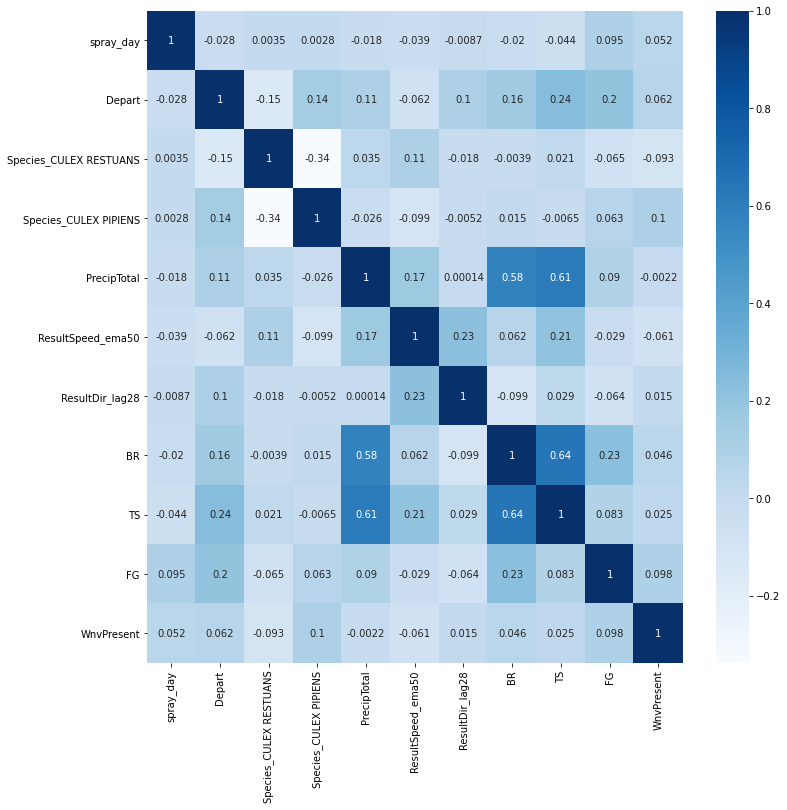

In [44]:
fig, ax = plt.subplots(figsize=(12,12))  
sns.heatmap(data.corr(), annot=True,cmap ='Blues')

In [42]:
data.to_pickle('data.pkl')
X.to_pickle('X.pkl')
y.to_pickle('y.pkl')

In [43]:
X.to_csv('X.csv')
y.to_csv('y.csv')